In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from importlib import reload

import models
import plotting
import utils.dataloaders as dl
import traintest as tt
import adversarial as adv
import utils.preproc as pre

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
base_model = torch.load('SavedModels/base_model.pth').to(device)
gmm_model = torch.load('SavedModels/gmm_model.pth').to(device)

In [14]:
def test_metrics(model, device, in_loader, out_loader, thresholds=torch.linspace(.1, 1., 1000).to(device)):
    with torch.no_grad():
        model.eval()
        conf_in = []
        conf_out = []
        count = 0.
        for ((batch_idx, (data_in, _)), (_, (data_out, _))) in zip(enumerate(in_loader),enumerate(out_loader)):
            count += 1
            data_in = data_in.to(device)
            data_out = data_out.to(device)

            output_in = model(data_in).max(1)[0].exp()
            output_out = model(data_out).max(1)[0].exp()

            conf_in.append(output_in)
            conf_out.append(output_out)
        conf_in = torch.cat(conf_in)
        conf_out = torch.cat(conf_out)
        
        tp = (conf_in[:,None] > thresholds[None,:]).sum(0).float()/(count*in_loader.batch_size)
        fp = (conf_out[:,None] > thresholds[None,:]).sum(0).float()/(count*out_loader.batch_size)
        
        mmc = conf_out.mean().item()
        auroc = -np.trapz(tp.cpu().numpy(), x=fp.cpu().numpy())
        fp95 = ((conf_out > 0.95).sum().float()/(count*out_loader.batch_size)).item()
        return mmc, auroc, fp95

In [15]:
def evaluate_model(model, device, base_loader, loaders):
    metrics = []
    mmc, _, _ = test_metrics(model, device, base_loader, base_loader)
    metrics.append(['MNIST', mmc, '-', '-'])
    for (name, data_loader) in loaders:
        mmc, auroc, fp95 = test_metrics(model, device, base_loader, data_loader)
        metrics.append([name, mmc, auroc, fp95])
    df = pd.DataFrame(metrics, columns = ['DataSet', 'MMC', 'AUROC', 'FPR@95'])
    return df.set_index('DataSet')

In [26]:
AdversarialNoiseLoader = adv.create_adv_noise_loader(base_model, dl.Noise_loader, device)

In [89]:
AdversarialSampleLoader = adv.create_adv_noise_loader(base_model, dl.MNIST_test_loader, device)

In [90]:
loaders = (
[('FMNIST', dl.FMNIST_test_loader), 
 ('EMNIST', dl.EMNIST_test_loader),
 ('GrayCIFAR10', dl.GrayCIFAR10_test_loader),
 ('Noise', dl.Noise_loader),
 ('Adv. Noise', AdversarialNoiseLoader ),
 ('Adv. Sample', AdversarialSampleLoader)]
)

In [91]:
df = evaluate_model(base_model, device, dl.MNIST_test_loader, loaders)

In [92]:
df

,MMC,AUROC,FPR@95
DataSet,,,
MNIST,0.992019,-,-
FMNIST,0.692214,0.983835,0.111
EMNIST,0.853812,0.868063,0.4885
GrayCIFAR10,0.632773,0.989706,0.0572
Noise,0.385521,0.999365,0
Adv. Noise,0.996400,0.47135,0.9884
Adv. Sample,0.999999,0.4203,1


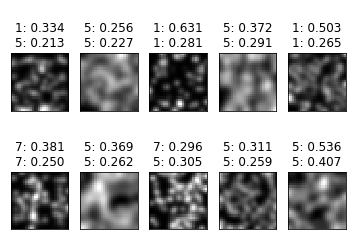

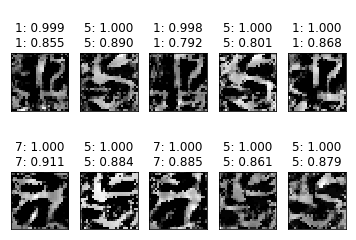

In [35]:
data = enumerate(dl.Noise_loader).__next__()[1][0]

y_base = base_model(data.to(device))
y = gmm_model(data.to(device))

plotting.plot_samples([y_base, y], data.detach().cpu())

data = adv.gen_adv_noise(base_model, device, data, epsilon=0.3, step_size=0.01)

y_base = base_model(data.to(device))
y = gmm_model(data.to(device))

plotting.plot_samples([y_base, y], data.detach().cpu())

In [348]:
lr = .0001
momentum = .9

optimizer_base = optim.SGD(base_model.parameters(), lr=lr, momentum=momentum, weight_decay=0.005)
for epoch in range(1):
    optimizer_base.param_groups[0]['lr'] *= .8
    tt.train_adv(base_model, device, dl.train_loader, optimizer_base, epoch)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.359271
Train Epoch: 0 [10000/60000 (17%)]	Loss: 2.532630
Train Epoch: 0 [20000/60000 (33%)]	Loss: 2.532842
Train Epoch: 0 [30000/60000 (50%)]	Loss: 2.532842
Train Epoch: 0 [40000/60000 (67%)]	Loss: 2.532846
Train Epoch: 0 [50000/60000 (83%)]	Loss: 2.532845


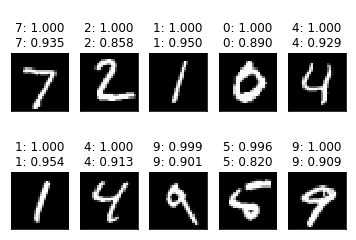

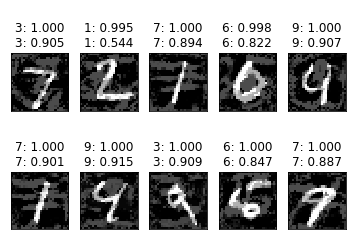

In [88]:
data, label = enumerate(dl.MNIST_test_loader).__next__()[1]

y_base = base_model(data.to(device))
y = gmm_model(data.to(device))

plotting.plot_samples([y_base, y], data.detach().cpu())

data = adv.gen_adv_sample(base_model, device, data, label, epsilon=0.3, step_size=0.01)

y_base = base_model(data.to(device))
y = gmm_model(data.to(device))

plotting.plot_samples([y_base, y], data.detach().cpu())